In [47]:
from dotenv import load_dotenv
from langchain_anthropic import ChatAnthropic

load_dotenv(dotenv_path="../.env", override=True)
model = ChatAnthropic(model='claude-3-opus-20240229')


In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

False

In [48]:
!pip install -U "langchain[anthropic]"

In [49]:
import os
from langchain.chat_models import init_chat_model

api_key = os.getenv("ANTHROPIC_API_KEY")
llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

In [50]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any
import pandas as pd

In [3]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../database/united_ops.db")

# Load full crew schedule including legality-related fields
mock_crew_schedule = pd.read_sql_query("""
    SELECT
        crew_id,
        name,
        assigned_flight,
        base,
        duty_start,
        duty_end,
        rest_hours_prior,
        last_flight_end,
        fatigue_score,
        role
    FROM crew
    WHERE duty_start IS NOT NULL AND duty_end IS NOT NULL
""", conn)

# Convert time fields to datetime
mock_crew_schedule[["duty_start", "duty_end", "last_flight_end"]] = mock_crew_schedule[
    ["duty_start", "duty_end", "last_flight_end"]
].apply(pd.to_datetime)

# Optionally load passengers for rebooking agent later
mock_passenger_itinerary = pd.read_sql_query("""
    SELECT passenger_id, flight_number, loyalty_tier
    FROM passengers
""", conn)

conn.close()

print(mock_crew_schedule.head())


     crew_id    name assigned_flight base          duty_start  \
0  DL7016_C0  Crew_0          DL7016  ORD 2025-06-25 03:56:00   
1  DL7016_C1  Crew_1          DL7016  ORD 2025-06-25 03:56:00   
2  DL7016_C2  Crew_2          DL7016  ORD 2025-06-25 03:56:00   
3  DL7016_C3  Crew_3          DL7016  ORD 2025-06-25 03:56:00   
4  DL7016_C4  Crew_4          DL7016  ORD 2025-06-25 03:56:00   

             duty_end  rest_hours_prior     last_flight_end  fatigue_score  \
0 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
1 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
2 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
3 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   
4 2025-06-25 07:36:00              10.0 2025-06-24 17:56:00            1.4   

        role  
0      Pilot  
1  Attendant  
2  Attendant  
3  Attendant  
4  Attendant  


### Shared agent state definition

In [4]:

from typing import Annotated, TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import pandas as pd
from operator import add

class SystemState(TypedDict):
    proposals: Annotated[List[Dict[str, Any]], add]  # Use 'add' operator for appending
    crew_schedule: pd.DataFrame
    passenger_itinerary: pd.DataFrame
    legality_flags: Annotated[List[str], add]  # Also append-only
    messages: Annotated[List[str], add]  # Also append-only
    iteration_count: int
    plan_summary: str
    final_plan: Dict[str, Any]

### Crew Ops Agent

In [73]:
from typing import List, Dict, Any
import pandas as pd
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_anthropic import ChatAnthropic
from langchain.prompts import ChatPromptTemplate


# Constants
MAX_DUTY_HOURS = 10
MIN_REST_HOURS = 10
MAX_FATIGUE_SCORE = 1.0

# === Claude-compatible Tools ===

@tool
def check_legality_tool(crew_schedule: List[Dict[str, Any]]) -> List[str]:
    """
    FAA legality check. Returns list of flight IDs violating duty hours, rest, or fatigue limits.
    """
    df = pd.DataFrame(crew_schedule)
    violations = []

    for flight_id, group in df.groupby("assigned_flight"):
        for _, row in group.iterrows():
            duty_hours = (pd.to_datetime(row["duty_end"]) - pd.to_datetime(row["duty_start"])).total_seconds() / 3600
            if duty_hours > MAX_DUTY_HOURS or row["rest_hours_prior"] < MIN_REST_HOURS or row["fatigue_score"] > MAX_FATIGUE_SCORE:
                violations.append(flight_id)
                break
    return list(set(violations))


@tool
def propose_substitutes_tool(violations: List[str], crew_schedule: List[Dict[str, Any]]) -> Dict[str, List[str]]:
    """
    Given violations and crew schedule, return substitute crew IDs per flight.
    Only uses unassigned crew who meet rest and fatigue constraints.
    """
    df = pd.DataFrame(crew_schedule)
    unassigned = df[df["assigned_flight"].isnull()].copy()
    substitutions = {}

    for flight_id in violations:
        needed_roles = df[df["assigned_flight"] == flight_id]["role"].value_counts()
        crew_ids = []

        for role, count in needed_roles.items():
            eligible = unassigned[
                (unassigned["rest_hours_prior"] >= MIN_REST_HOURS) &
                (unassigned["fatigue_score"] <= MAX_FATIGUE_SCORE) &
                (unassigned["role"] == role)
            ]
            selected = eligible.head(count)
            crew_ids.extend(selected["crew_id"].tolist())
            unassigned = unassigned[~unassigned["crew_id"].isin(selected["crew_id"])]

        substitutions[flight_id] = crew_ids

    return substitutions

# === Claude CrewOps Agent ===

def crew_ops_anthropic_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    print("🧑‍✈️ Claude CrewOpsAgent activated")

    state.setdefault("messages", []).append("Claude CrewOpsAgent analyzing FAA legality")

    crew_schedule_dict = state["crew_schedule"].to_dict(orient="records")

    llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0.1)

    tools = [check_legality_tool, propose_substitutes_tool]

    prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a flight legality compliance agent.\n"
     "Step 1: Use `check_legality_tool` to find flights violating FAA rules.\n"
     "Step 2: Use `propose_substitutes_tool` to find legal replacements for flagged flights.\n"
     "Use only unassigned crew who meet rest and fatigue limits."),
    ("user", "{input}"),
    ("ai", "{agent_scratchpad}")
    ])

ChatPromptTemplate.from_messages([
    ("system", 
     "You are a flight legality compliance agent.\n"
     "First, use `check_legality_tool` to find flights violating FAA rules.\n"
     "Then use `propose_substitutes_tool` to find legal replacements.\n"
     "Use only unassigned crew who meet rest and fatigue limits."),
    ("ai", "{agent_scratchpad}")
])


    
    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    # Call the agent with crew schedule as input
    result = agent_executor.invoke({
        "crew_schedule": crew_schedule_dict
    })

    state["messages"].append("Claude CrewOpsAgent completed analysis")
    return {
        **state,
        "proposals": [{"CrewOpsAgent": result}]
    }


IndentationError: unexpected indent (2593268191.py, line 95)

### PlannerAgent Node

In [6]:
def evaluate_tradeoffs(proposals: List[Dict[str, Any]]) -> Dict[str, Any]:
    # Simple passthrough with score placeholder
    return {"selected_plan": proposals or [{"PlannerAgent": "No input received"}]}

def generate_plan_summary(plan: Dict[str, Any]) -> str:
    summary_lines = []
    for i, proposal in enumerate(plan.get("selected_plan", [])):
        for agent, value in proposal.items():
            summary_lines.append(f"• From {agent}: {value}")
    return "\n".join(summary_lines) if summary_lines else "No agent contributions in this round."

def merge_agent_states(states: List[Dict[str, Any]]) -> Dict[str, Any]:
    merged = {}
    for state in states:
        merged.update(state)
    return merged

def planner_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    print("🧠 PlannerAgent activated")
    state.setdefault("messages", []).append("PlannerAgent checking for proposals")
    state["iteration_count"] = state.get("iteration_count", 0) + 1

    proposals = state.get("proposals", [])
    if not proposals:
        state["messages"].append("No agent proposals received. Continuing.")
        plan = {"selected_plan": []}
        summary = "No agent contributions in this round."
    else:
        plan = evaluate_tradeoffs(proposals)
        summary = generate_plan_summary(plan)
        state["messages"].append("PlannerAgent scored and summarized plan.")
        state["messages"].extend([f"Received from {list(p.keys())[0]}: {list(p.values())[0]}" for p in proposals])

    # Stop after 2 iterations
    if state["iteration_count"] >= 2:
        state["__done__"] = True

    return {
        **state,
        "final_plan": plan,
        "plan_summary": summary
    }


## Passenger Rebooking Agent

In [8]:
def passenger_rebooking_agent(state: SystemState) -> SystemState:
    print("🧑‍💼 PassengerRebookingAgent activated")
    if "messages" not in state:
        state["messages"] = []
    state["messages"].append("PassengerRebookingAgent reviewed passenger disruptions")
    
    # Stub logic: find passengers with cancelled or missed connections
    itinerary = state.get("passenger_itinerary", pd.DataFrame())
    affected = []
    proposals = []
    for idx, row in itinerary.iterrows():
        if row.get("status") == "cancelled" or row.get("missed_connection", False):
            affected.append(row["passenger_id"])
            # Stub: propose a new flight (just append '_rebooked' to flight_id)
            proposals.append({
                "passenger_id": row["passenger_id"],
                "original_flight": row["flight_id"],
                "rebooked_flight": f"{row['flight_id']}_rebooked"
            })
    return {
        **state,
        "proposals": state["proposals"] + [{"PassengerRebookingAgent": proposals}],
        "rebooking_proposals": proposals
    }

## DispatchOpsAgent

In [10]:
def has_legality_violations(state: Dict[str, Any]) -> bool:
    """
    Checks for legality violations flagged by CrewOpsAgent.
    """
    return bool(state.get("legality_flags"))

def detect_fuel_capacity(fuel_data: Dict[str, Any]) -> Dict[str, str]:
    """
    Checks fuel readiness before dispatch using keys:
    'FUEL ORDER' or 'FUEL FINAL'
    """
    if "FUEL FINAL" in fuel_data:
        return {}
    if "FUEL ORDER" in fuel_data:
        return {"FUEL_REQUESTED": "Airplane needs fuel prior to departure."}
    return {"FUEL_DATA_MISSING": "No fuel data provided: both FUEL ORDER and FUEL FINAL are missing."}

def detect_weather_risks(weather_data: Dict[str, str]) -> Dict[str, str]:
    """
    Detects weather-related risks at the departure location from METAR codes.
    """
    metar = weather_data.get("departure", "")
    delay_codes = {
        "TS": "Thunderstorm in vicinity (delay expected)",
        "FG": "Fog reported (delay expected)",
        "SN": "Snow present at departure (delay expected)",
    }
    return {code: msg for code, msg in delay_codes.items() if code in metar}

def dispatch_ops_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    LangGraph-compatible DispatchOpsAgent.
    Evaluates legality, fuel, and weather for dispatch readiness.
    """
    print("🛰️ DispatchOpsAgent activated")
    state.setdefault("messages", []).append("DispatchOpsAgent checking dispatch readiness")

    violations = {}

    # Check crew legality
    if has_legality_violations(state):
        violations["CREW_LEGALITY"] = "One or more flights have FAA legality violations."

    # Check weather risks
    violations.update(detect_weather_risks(state.get("weather_data", {}))) ## change to weather MCP

    # Check fuel readiness
    violations.update(detect_fuel_capacity(state.get("fuel_data", {})))

    # Final decision
    status = "EXCEPTION" if violations else "GREEN"
    message = (
        "DispatchOpsAgent found dispatch violations."
        if violations else "DispatchOpsAgent approved dispatch readiness."
    )
    state["messages"].append(message)

    return {
        **state,
        "dispatch_status": status,
        "dispatch_violations": violations,
    }

### Graph Assembly

In [74]:
from langgraph.graph import StateGraph, END

# Create sequential graph with planner coming last
graph = StateGraph(SystemState)

# Add nodes
graph.add_node("crew_ops", crew_ops_anthropic_agent)
graph.add_node("passenger_rebook", passenger_rebooking_agent)
graph.add_node("dispatch_ops", dispatch_ops_agent)
graph.add_node("planner", planner_agent)

# Define edges
graph.set_entry_point("crew_ops")
graph.add_edge("crew_ops", "passenger_rebook")
graph.add_edge("passenger_rebook", "dispatch_ops")
graph.add_edge("dispatch_ops", "planner")

# Define end node
graph.set_finish_point("planner")

# Compile the graph
plan_executor = graph.compile()

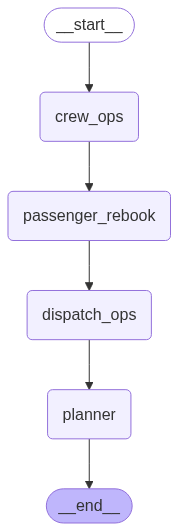

In [75]:
from IPython.display import Image, display

png = plan_executor.get_graph().draw_mermaid_png()
display(Image(png))

In [ ]:
initial_state = {
    "proposals": [],
    "crew_schedule": mock_crew_schedule,
    "passenger_itinerary": mock_passenger_itinerary
}

output = plan_executor.invoke(initial_state)

# Print overall message trail
print("📝 Final State Messages:")
for msg in output.get("messages", []):
    print("-", msg)

# Print CrewOpsAgent proposals if present
crew_proposals_found = False
for proposal in output.get("proposals", []):
    if "CrewOpsAgent" in proposal:
        crew_proposals_found = True
        print("\n🧑‍✈️ CrewOpsAgent Proposals:")
        if not proposal["CrewOpsAgent"]:
            print("  ⚠️ No proposals made.")
        else:
            for flight_id, crew_list in proposal["CrewOpsAgent"].items():
                if crew_list:
                    print(f"  Flight {flight_id}: Substitute crew → {crew_list}")
                else:
                    print(f"  ⚠️ Flight {flight_id}: No available substitute crew")

if not crew_proposals_found:
    print("\n❌ No proposals from CrewOpsAgent.")


🧑‍✈️ Claude CrewOpsAgent activated


> Entering new AgentExecutor chain...


KeyError: "Input to ChatPromptTemplate is missing variables {'input'}.  Expected: ['agent_scratchpad', 'input'] Received: ['crew_schedule', 'intermediate_steps', 'agent_scratchpad']\nNote: if you intended {input} to be part of the string and not a variable, please escape it with double curly braces like: '{{input}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "